In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

### 0. Util function

In [3]:
def plot_KLML(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    '''
    plot KL ML loss together
    '''
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    losses_ML_val = np.concatenate([hist_ML[1], hist_KL[2][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='steelblue',label='traning loss')
    axes[0].plot(xticks, losses_ML_val, color='darkorange',label='validation loss')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].legend(ncol=1, loc='upper right', frameon=False)
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    losses_KL_val = hist_KL[2][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='steelblue',label='traning loss')
    axes[1].plot(xticks, losses_KL_val, color='darkorange',label='validation loss')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].legend(ncol=1, loc='upper right', frameon=False)
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    
    return fig, axes

In [4]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [5]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [6]:
def plot_potential(cbar=True, orientation='vertical', figsize=(4, 5.5)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 7, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
    plt.xticks([-2, 0, 2])
    plt.yticks([-5, 0, 5])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

In [7]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [8]:
def getx(x):
    return x[:, 0]

### 1. Explore Double-well potential

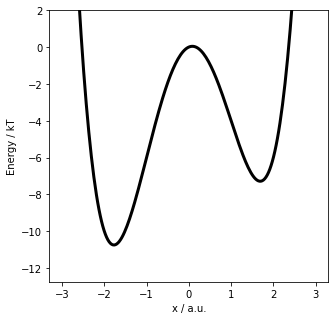

In [9]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();

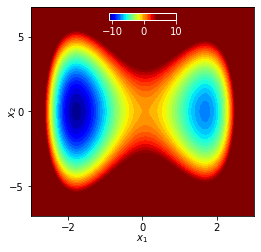

In [10]:
plot_potential(orientation='horizontal')

### 2. Generate Simulation Data as Training Dataset

In [11]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [12]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5, 0, 'Probability')

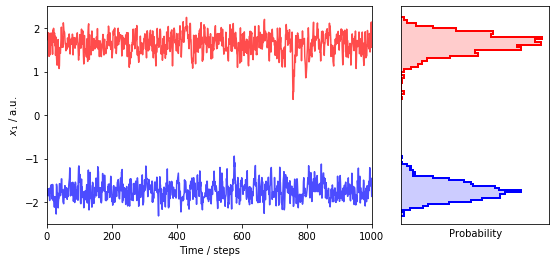

In [13]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('$x_1$ / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')

In [14]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [15]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

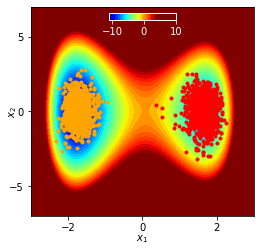

In [16]:
cbar = plot_potential(cbar=True, figsize = (4,5.5), orientation='horizontal')
plt.plot(traj_left[:,0],traj_left[:,1], color='orange',linewidth=0,marker='.')
plt.plot(traj_right[:,0],traj_right[:,1], color='red',linewidth=0,marker='.')

### 3. Training using InvNet


In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


### 3.1 pure ML loss training

In [18]:
network1 = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'log_scale:0' shape=(1, 2) dtype=float32> log_scaling_factors
tracking <tf.Variable 'log_scale:0' shape=(1, 2) dtype=float32> log_scaling_factors


In [19]:
hist_ML = network1.train_ML(x, xval=xval, epochs=700, batch_size=128, std=1.0, 
                                               verbose=1, return_test_energies=True)

Epoch 0/700 loss 1.8288 2.1545 
Epoch 1/700 loss 1.7818 2.1995 
Epoch 2/700 loss 1.7686 2.2759 
Epoch 3/700 loss 1.6633 1.9478 
Epoch 4/700 loss 1.4287 2.0253 
Epoch 5/700 loss 1.4155 1.9114 
Epoch 6/700 loss 1.3939 1.9952 
Epoch 7/700 loss 1.6272 1.9620 
Epoch 8/700 loss 1.3742 2.1497 
Epoch 9/700 loss 1.5125 1.9690 
Epoch 10/700 loss 1.5471 2.3245 
Epoch 11/700 loss 1.6060 1.8915 
Epoch 12/700 loss 1.6645 1.9931 
Epoch 13/700 loss 1.4660 1.6459 
Epoch 14/700 loss 1.4336 1.8461 
Epoch 15/700 loss 1.4847 1.8447 
Epoch 16/700 loss 1.6253 1.9103 
Epoch 17/700 loss 1.4390 1.8081 
Epoch 18/700 loss 1.3738 1.7238 
Epoch 19/700 loss 1.5029 1.9626 
Epoch 20/700 loss 1.4527 1.7547 
Epoch 21/700 loss 1.4091 1.6446 
Epoch 22/700 loss 1.2509 2.1186 
Epoch 23/700 loss 1.2979 1.9295 
Epoch 24/700 loss 1.4657 1.6940 
Epoch 25/700 loss 1.5035 1.6155 
Epoch 26/700 loss 1.2630 1.8788 
Epoch 27/700 loss 1.3352 1.8530 
Epoch 28/700 loss 1.3187 1.6769 
Epoch 29/700 loss 1.2907 1.4955 
Epoch 30/700 loss 1.

Epoch 245/700 loss 0.3121 0.5425 
Epoch 246/700 loss 0.2064 0.4162 
Epoch 247/700 loss 0.2580 0.4339 
Epoch 248/700 loss 0.3357 0.4392 
Epoch 249/700 loss 0.1866 0.7055 
Epoch 250/700 loss 0.2794 0.6051 
Epoch 251/700 loss 0.2817 0.4404 
Epoch 252/700 loss 0.1410 0.4930 
Epoch 253/700 loss 0.1910 0.5213 
Epoch 254/700 loss 0.2203 0.5712 
Epoch 255/700 loss 0.3472 0.4413 
Epoch 256/700 loss 0.2708 0.4495 
Epoch 257/700 loss 0.2947 0.4973 
Epoch 258/700 loss 0.1560 0.2667 
Epoch 259/700 loss 0.3109 0.4660 
Epoch 260/700 loss 0.2231 0.4320 
Epoch 261/700 loss 0.3171 0.4251 
Epoch 262/700 loss 0.2334 0.5118 
Epoch 263/700 loss 0.2591 0.6173 
Epoch 264/700 loss 0.1987 0.6986 
Epoch 265/700 loss 0.1482 0.5424 
Epoch 266/700 loss 0.2836 0.4287 
Epoch 267/700 loss 0.2944 0.6857 
Epoch 268/700 loss 0.2717 0.5351 
Epoch 269/700 loss 0.3032 0.4980 
Epoch 270/700 loss 0.1807 0.4684 
Epoch 271/700 loss 0.2345 0.5381 
Epoch 272/700 loss 0.2437 0.3874 
Epoch 273/700 loss 0.2325 0.3812 
Epoch 274/700 

Epoch 486/700 loss 0.1411 0.5179 
Epoch 487/700 loss 0.0741 0.4160 
Epoch 488/700 loss 0.1494 0.5278 
Epoch 489/700 loss 0.1323 0.3600 
Epoch 490/700 loss 0.0558 0.4455 
Epoch 491/700 loss 0.1917 0.4274 
Epoch 492/700 loss 0.1495 0.5241 
Epoch 493/700 loss 0.1639 0.6344 
Epoch 494/700 loss 0.1802 0.8218 
Epoch 495/700 loss 0.0323 0.3641 
Epoch 496/700 loss 0.0506 0.3767 
Epoch 497/700 loss 0.1867 0.4552 
Epoch 498/700 loss 0.0371 0.3890 
Epoch 499/700 loss 0.1691 0.5472 
Epoch 500/700 loss 0.0408 0.6227 
Epoch 501/700 loss 0.2288 0.3960 
Epoch 502/700 loss -0.0138 0.4445 
Epoch 503/700 loss 0.1595 0.5240 
Epoch 504/700 loss 0.2758 0.2205 
Epoch 505/700 loss 0.0525 0.5948 
Epoch 506/700 loss 0.0885 0.3835 
Epoch 507/700 loss 0.1656 0.3897 
Epoch 508/700 loss 0.0978 0.5911 
Epoch 509/700 loss 0.1386 0.4210 
Epoch 510/700 loss 0.1782 0.4326 
Epoch 511/700 loss 0.1317 0.3656 
Epoch 512/700 loss -0.0261 0.3787 
Epoch 513/700 loss 0.1788 0.4754 
Epoch 514/700 loss 0.1797 0.4210 
Epoch 515/70

### 3.2 pure KL loss training

In [20]:
network2 = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0
tracking <tf.Variable 'log_scale_1:0' shape=(1, 2) dtype=float32> log_scaling_factors
tracking <tf.Variable 'log_scale_1:0' shape=(1, 2) dtype=float32> log_scaling_factors


In [21]:
hist_KL = network2.train_flexible(x, xval=xval, lr=0.001, epochs=700, batch_size=1000, 
                                   std=1.0,
                                   weight_ML=0.01, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                   weight_RCEnt=0.0, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                   temperature=1.0, explore=1.0, verbose=1,
                                   return_test_energies=True)

Epoch 0/700 loss -2.1236 -2.6789 scaling_xz_2_loss 1.8348 2.1341 index_layer_12_loss -2.1420 -2.7002 
Epoch 1/700 loss -2.5418 -2.6985 scaling_xz_2_loss 1.8590 2.1476 index_layer_12_loss -2.5604 -2.7200 
Epoch 2/700 loss -2.6048 -2.9367 scaling_xz_2_loss 1.8279 2.1538 index_layer_12_loss -2.6231 -2.9583 
Epoch 3/700 loss -2.8415 -3.0103 scaling_xz_2_loss 1.9285 2.3583 index_layer_12_loss -2.8608 -3.0339 
Epoch 4/700 loss -2.8961 -2.8139 scaling_xz_2_loss 2.0293 2.3525 index_layer_12_loss -2.9164 -2.8374 
Epoch 5/700 loss -2.8911 -2.5386 scaling_xz_2_loss 2.0314 2.6127 index_layer_12_loss -2.9114 -2.5647 
Epoch 6/700 loss -2.5269 -2.8812 scaling_xz_2_loss 2.1145 2.5842 index_layer_12_loss -2.5480 -2.9070 
Epoch 7/700 loss -3.1862 -3.1094 scaling_xz_2_loss 2.1466 2.3827 index_layer_12_loss -3.2077 -3.1332 
Epoch 8/700 loss -2.5577 -3.2084 scaling_xz_2_loss 2.0523 2.5427 index_layer_12_loss -2.5782 -3.2338 
Epoch 9/700 loss -3.2490 -3.4487 scaling_xz_2_loss 2.0790 2.2929 index_layer_12_lo

Epoch 80/700 loss -6.7675 -6.7573 scaling_xz_2_loss 2.8109 2.7984 index_layer_12_loss -6.7956 -6.7853 
Epoch 81/700 loss -6.6237 -6.4909 scaling_xz_2_loss 2.5305 2.8982 index_layer_12_loss -6.6490 -6.5199 
Epoch 82/700 loss -6.5676 -6.7744 scaling_xz_2_loss 2.4633 2.7179 index_layer_12_loss -6.5922 -6.8016 
Epoch 83/700 loss -6.7289 -6.6177 scaling_xz_2_loss 2.5343 2.7233 index_layer_12_loss -6.7543 -6.6450 
Epoch 84/700 loss -6.5570 -6.7088 scaling_xz_2_loss 2.5870 2.7715 index_layer_12_loss -6.5829 -6.7365 
Epoch 85/700 loss -6.5233 -6.7166 scaling_xz_2_loss 2.7031 2.8091 index_layer_12_loss -6.5503 -6.7446 
Epoch 86/700 loss -6.7115 -6.6943 scaling_xz_2_loss 2.4824 2.7911 index_layer_12_loss -6.7364 -6.7222 
Epoch 87/700 loss -6.7712 -6.7737 scaling_xz_2_loss 2.3181 2.7617 index_layer_12_loss -6.7944 -6.8013 
Epoch 88/700 loss -6.6151 -6.4972 scaling_xz_2_loss 2.3954 2.6413 index_layer_12_loss -6.6390 -6.5236 
Epoch 89/700 loss -6.7244 -6.8652 scaling_xz_2_loss 2.5817 2.6584 index_l

Epoch 159/700 loss -7.1163 -7.1833 scaling_xz_2_loss 2.6413 2.5216 index_layer_12_loss -7.1428 -7.2085 
Epoch 160/700 loss -6.9544 -6.7827 scaling_xz_2_loss 2.6197 2.7648 index_layer_12_loss -6.9806 -6.8103 
Epoch 161/700 loss -7.0974 -6.9933 scaling_xz_2_loss 2.7568 2.9859 index_layer_12_loss -7.1249 -7.0231 
Epoch 162/700 loss -7.0751 -7.0776 scaling_xz_2_loss 2.6286 2.7798 index_layer_12_loss -7.1014 -7.1054 
Epoch 163/700 loss -7.0748 -7.0861 scaling_xz_2_loss 2.5544 2.6773 index_layer_12_loss -7.1004 -7.1129 
Epoch 164/700 loss -7.0872 -7.1926 scaling_xz_2_loss 2.6911 2.7757 index_layer_12_loss -7.1141 -7.2204 
Epoch 165/700 loss -7.0810 -7.1907 scaling_xz_2_loss 2.7391 2.6604 index_layer_12_loss -7.1084 -7.2173 
Epoch 166/700 loss -6.9534 -7.0148 scaling_xz_2_loss 2.6177 2.7726 index_layer_12_loss -6.9796 -7.0426 
Epoch 167/700 loss -7.0612 -7.1828 scaling_xz_2_loss 2.6040 2.8254 index_layer_12_loss -7.0873 -7.2111 
Epoch 168/700 loss -7.1595 -7.0276 scaling_xz_2_loss 2.6640 2.60

Epoch 238/700 loss -7.1873 -7.2187 scaling_xz_2_loss 2.7069 3.0030 index_layer_12_loss -7.2144 -7.2487 
Epoch 239/700 loss -7.3406 -7.4069 scaling_xz_2_loss 2.7626 2.9648 index_layer_12_loss -7.3682 -7.4366 
Epoch 240/700 loss -7.3042 -7.2338 scaling_xz_2_loss 2.7620 2.9385 index_layer_12_loss -7.3318 -7.2632 
Epoch 241/700 loss -7.1443 -7.2118 scaling_xz_2_loss 2.6474 2.7804 index_layer_12_loss -7.1708 -7.2396 
Epoch 242/700 loss -7.1789 -7.2365 scaling_xz_2_loss 2.7043 2.8194 index_layer_12_loss -7.2059 -7.2647 
Epoch 243/700 loss -7.3642 -7.3252 scaling_xz_2_loss 2.6622 2.7944 index_layer_12_loss -7.3908 -7.3532 
Epoch 244/700 loss -7.4545 -7.3442 scaling_xz_2_loss 2.6377 2.8443 index_layer_12_loss -7.4809 -7.3726 
Epoch 245/700 loss -7.1037 -7.1872 scaling_xz_2_loss 2.7631 2.7952 index_layer_12_loss -7.1314 -7.2152 
Epoch 246/700 loss -7.3605 -7.4022 scaling_xz_2_loss 2.6900 3.0502 index_layer_12_loss -7.3874 -7.4327 
Epoch 247/700 loss -7.3937 -7.3612 scaling_xz_2_loss 2.5276 2.94

Epoch 317/700 loss -7.4324 -7.5181 scaling_xz_2_loss 3.0523 3.1872 index_layer_12_loss -7.4630 -7.5500 
Epoch 318/700 loss -7.3439 -7.5022 scaling_xz_2_loss 2.9993 3.2299 index_layer_12_loss -7.3739 -7.5345 
Epoch 319/700 loss -7.5139 -7.4711 scaling_xz_2_loss 2.9911 3.3477 index_layer_12_loss -7.5438 -7.5046 
Epoch 320/700 loss -7.4416 -7.4280 scaling_xz_2_loss 3.0081 3.2252 index_layer_12_loss -7.4717 -7.4603 
Epoch 321/700 loss -7.5489 -7.3805 scaling_xz_2_loss 3.1366 3.1955 index_layer_12_loss -7.5803 -7.4125 
Epoch 322/700 loss -7.4547 -7.5345 scaling_xz_2_loss 2.7810 3.1038 index_layer_12_loss -7.4825 -7.5656 
Epoch 323/700 loss -7.4937 -7.3843 scaling_xz_2_loss 2.8872 3.2150 index_layer_12_loss -7.5226 -7.4164 
Epoch 324/700 loss -7.4056 -7.5917 scaling_xz_2_loss 2.9260 3.3651 index_layer_12_loss -7.4349 -7.6253 
Epoch 325/700 loss -7.4618 -7.4655 scaling_xz_2_loss 2.8528 3.3796 index_layer_12_loss -7.4903 -7.4993 
Epoch 326/700 loss -7.5101 -7.3077 scaling_xz_2_loss 3.1138 3.20

Epoch 396/700 loss -7.6576 -7.5171 scaling_xz_2_loss 2.9312 3.3685 index_layer_12_loss -7.6869 -7.5507 
Epoch 397/700 loss -7.7268 -7.5832 scaling_xz_2_loss 2.9893 3.7404 index_layer_12_loss -7.7567 -7.6206 
Epoch 398/700 loss -7.5567 -7.6623 scaling_xz_2_loss 3.0810 3.5355 index_layer_12_loss -7.5875 -7.6976 
Epoch 399/700 loss -7.5362 -7.6259 scaling_xz_2_loss 2.6758 3.6650 index_layer_12_loss -7.5630 -7.6626 
Epoch 400/700 loss -7.6956 -7.6136 scaling_xz_2_loss 3.0784 3.3645 index_layer_12_loss -7.7263 -7.6473 
Epoch 401/700 loss -7.5991 -7.5020 scaling_xz_2_loss 2.7469 3.7068 index_layer_12_loss -7.6266 -7.5391 
Epoch 402/700 loss -7.6500 -7.6488 scaling_xz_2_loss 2.7068 3.7184 index_layer_12_loss -7.6771 -7.6860 
Epoch 403/700 loss -7.7591 -7.6443 scaling_xz_2_loss 2.9212 3.5471 index_layer_12_loss -7.7883 -7.6798 
Epoch 404/700 loss -7.5153 -7.5331 scaling_xz_2_loss 3.0386 3.9879 index_layer_12_loss -7.5457 -7.5730 
Epoch 405/700 loss -7.5830 -7.6452 scaling_xz_2_loss 2.7629 3.61

Epoch 475/700 loss -7.7308 -7.6942 scaling_xz_2_loss 3.2520 3.6015 index_layer_12_loss -7.7633 -7.7302 
Epoch 476/700 loss -7.7649 -7.6281 scaling_xz_2_loss 3.0389 3.5412 index_layer_12_loss -7.7952 -7.6636 
Epoch 477/700 loss -7.7393 -7.7574 scaling_xz_2_loss 2.9679 3.7804 index_layer_12_loss -7.7690 -7.7952 
Epoch 478/700 loss -7.7707 -7.8166 scaling_xz_2_loss 3.0114 4.7413 index_layer_12_loss -7.8008 -7.8640 
Epoch 479/700 loss -7.8278 -7.7345 scaling_xz_2_loss 3.3185 3.8168 index_layer_12_loss -7.8610 -7.7727 
Epoch 480/700 loss -7.7582 -7.6840 scaling_xz_2_loss 3.4183 3.5628 index_layer_12_loss -7.7924 -7.7196 
Epoch 481/700 loss -7.7939 -7.8337 scaling_xz_2_loss 3.3206 4.0117 index_layer_12_loss -7.8271 -7.8738 
Epoch 482/700 loss -7.6717 -7.7188 scaling_xz_2_loss 3.1558 3.9470 index_layer_12_loss -7.7033 -7.7583 
Epoch 483/700 loss -7.6368 -7.6984 scaling_xz_2_loss 3.6354 4.2479 index_layer_12_loss -7.6731 -7.7409 
Epoch 484/700 loss -7.7087 -7.7336 scaling_xz_2_loss 3.2551 4.00

Epoch 554/700 loss -7.8198 -7.8332 scaling_xz_2_loss 3.2566 4.3000 index_layer_12_loss -7.8523 -7.8762 
Epoch 555/700 loss -7.7552 -7.7929 scaling_xz_2_loss 3.1241 4.6443 index_layer_12_loss -7.7864 -7.8393 
Epoch 556/700 loss -7.9064 -7.7986 scaling_xz_2_loss 3.4005 4.7041 index_layer_12_loss -7.9404 -7.8457 
Epoch 557/700 loss -7.7986 -7.8004 scaling_xz_2_loss 3.3350 4.2335 index_layer_12_loss -7.8319 -7.8427 
Epoch 558/700 loss -7.8608 -7.8299 scaling_xz_2_loss 3.3388 3.8987 index_layer_12_loss -7.8942 -7.8688 
Epoch 559/700 loss -7.9450 -7.7996 scaling_xz_2_loss 3.1476 4.6505 index_layer_12_loss -7.9765 -7.8461 
Epoch 560/700 loss -7.8958 -7.8849 scaling_xz_2_loss 3.2401 4.1079 index_layer_12_loss -7.9282 -7.9259 
Epoch 561/700 loss -7.8265 -7.8434 scaling_xz_2_loss 3.3975 4.7228 index_layer_12_loss -7.8605 -7.8906 
Epoch 562/700 loss -7.6954 -7.7601 scaling_xz_2_loss 3.0712 4.3174 index_layer_12_loss -7.7262 -7.8033 
Epoch 563/700 loss -7.8116 -7.8273 scaling_xz_2_loss 3.1804 4.50

Epoch 633/700 loss -7.8786 -7.8229 scaling_xz_2_loss 3.1765 4.4457 index_layer_12_loss -7.9104 -7.8674 
Epoch 634/700 loss -7.9082 -7.7893 scaling_xz_2_loss 3.4987 5.3667 index_layer_12_loss -7.9432 -7.8430 
Epoch 635/700 loss -7.9335 -7.8981 scaling_xz_2_loss 3.1442 4.5642 index_layer_12_loss -7.9650 -7.9437 
Epoch 636/700 loss -7.8867 -7.7685 scaling_xz_2_loss 3.0574 4.4806 index_layer_12_loss -7.9173 -7.8133 
Epoch 637/700 loss -7.9459 -7.7993 scaling_xz_2_loss 3.4042 4.5730 index_layer_12_loss -7.9800 -7.8450 
Epoch 638/700 loss -7.8893 -7.8538 scaling_xz_2_loss 3.7013 5.3553 index_layer_12_loss -7.9264 -7.9073 
Epoch 639/700 loss -7.8679 -7.9995 scaling_xz_2_loss 3.5239 4.8791 index_layer_12_loss -7.9032 -8.0482 
Epoch 640/700 loss -7.9141 -7.8279 scaling_xz_2_loss 3.2173 5.4772 index_layer_12_loss -7.9463 -7.8827 
Epoch 641/700 loss -7.8489 -7.7974 scaling_xz_2_loss 3.3986 5.4572 index_layer_12_loss -7.8828 -7.8519 
Epoch 642/700 loss -7.8942 -7.9791 scaling_xz_2_loss 3.4605 4.53

### Compare ML vs KL loss

Text(0, 0.5, 'KL loss')

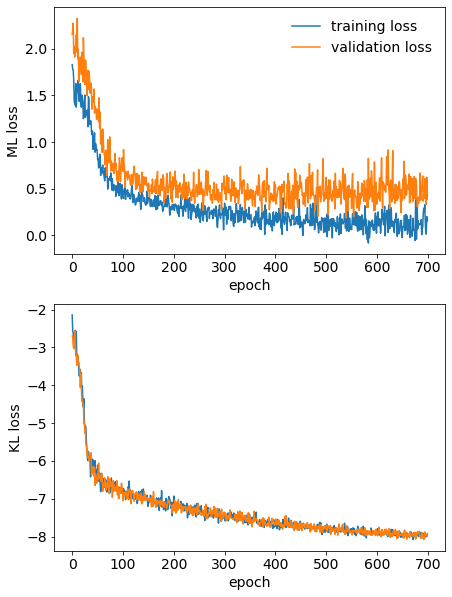

In [22]:
from matplotlib import rcParams
rcParams.update({'font.size':14})

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
axes[0].plot(list(range(700)), hist_ML[0], label='training loss')
axes[0].plot(list(range(700)), hist_ML[1], label='validation loss')
axes[0].legend(ncol=1, loc='upper right', frameon=False)
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('ML loss')


axes[1].plot(list(range(700)), hist_KL[1][:,2], label='training loss')
axes[1].plot(list(range(700)), hist_KL[2][:,2], label='validation loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('KL loss')


### 3.3 Joint learning : KL + ML loss

In [23]:
network3 = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0
tracking <tf.Variable 'log_scale_2:0' shape=(1, 2) dtype=float32> log_scaling_factors
tracking <tf.Variable 'log_scale_2:0' shape=(1, 2) dtype=float32> log_scaling_factors


In [24]:
hist1 = network3.train_ML(x, xval=xval, epochs=200, batch_size=128, std=1.0, 
                                               verbose=1, return_test_energies=True)
hist2 = network3.train_flexible(x, xval=xval, lr=0.001, epochs=500, batch_size=1000, 
                                   std=1.0,
                                   weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                   weight_RCEnt=0.0, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                   temperature=1.0, explore=1.0, verbose=1,
                                   return_test_energies=True)

Epoch 0/200 loss 2.0230 2.2261 
Epoch 1/200 loss 1.8810 2.1086 
Epoch 2/200 loss 1.8974 2.1046 
Epoch 3/200 loss 1.8566 2.1636 
Epoch 4/200 loss 1.8484 2.0941 
Epoch 5/200 loss 1.8408 1.8318 
Epoch 6/200 loss 1.6832 2.0610 
Epoch 7/200 loss 1.5971 2.1855 
Epoch 8/200 loss 1.6162 1.9379 
Epoch 9/200 loss 1.6693 2.0418 
Epoch 10/200 loss 1.5766 1.9469 
Epoch 11/200 loss 1.4553 1.8428 
Epoch 12/200 loss 1.4410 1.8854 
Epoch 13/200 loss 1.4764 2.1086 
Epoch 14/200 loss 1.4485 1.7772 
Epoch 15/200 loss 1.4718 1.7093 
Epoch 16/200 loss 1.6151 2.1683 
Epoch 17/200 loss 1.5958 2.3914 
Epoch 18/200 loss 1.5454 2.0586 
Epoch 19/200 loss 1.2990 2.1319 
Epoch 20/200 loss 1.5562 2.0123 
Epoch 21/200 loss 1.3402 1.8704 
Epoch 22/200 loss 1.2590 2.0024 
Epoch 23/200 loss 1.4809 1.9157 
Epoch 24/200 loss 1.5318 1.7890 
Epoch 25/200 loss 1.4038 1.7737 
Epoch 26/200 loss 1.3249 1.9592 
Epoch 27/200 loss 1.3638 1.9524 
Epoch 28/200 loss 1.4411 1.9573 
Epoch 29/200 loss 1.3568 1.8682 
Epoch 30/200 loss 1.

Epoch 15/500 loss -5.9927 -6.0325 scaling_xz_3_loss 0.4177 0.5768 index_layer_18_loss -6.4104 -6.6093 
Epoch 16/500 loss -6.0249 -5.9538 scaling_xz_3_loss 0.4249 0.5782 index_layer_18_loss -6.4498 -6.5320 
Epoch 17/500 loss -6.3264 -5.9771 scaling_xz_3_loss 0.4275 0.5804 index_layer_18_loss -6.7540 -6.5575 
Epoch 18/500 loss -6.2190 -6.0648 scaling_xz_3_loss 0.4403 0.5620 index_layer_18_loss -6.6593 -6.6268 
Epoch 19/500 loss -6.1340 -5.9862 scaling_xz_3_loss 0.4226 0.5208 index_layer_18_loss -6.5566 -6.5070 
Epoch 20/500 loss -6.1815 -6.2636 scaling_xz_3_loss 0.4004 0.5036 index_layer_18_loss -6.5819 -6.7673 
Epoch 21/500 loss -6.2738 -6.2486 scaling_xz_3_loss 0.4147 0.5295 index_layer_18_loss -6.6885 -6.7781 
Epoch 22/500 loss -6.3034 -5.9426 scaling_xz_3_loss 0.4385 0.5641 index_layer_18_loss -6.7419 -6.5067 
Epoch 23/500 loss -6.1806 -6.1407 scaling_xz_3_loss 0.4472 0.5523 index_layer_18_loss -6.6278 -6.6929 
Epoch 24/500 loss -6.3120 -6.1890 scaling_xz_3_loss 0.4223 0.5132 index_l

Epoch 95/500 loss -6.9189 -6.7624 scaling_xz_3_loss 0.4590 0.5366 index_layer_18_loss -7.3779 -7.2990 
Epoch 96/500 loss -6.8492 -6.8238 scaling_xz_3_loss 0.4064 0.5282 index_layer_18_loss -7.2556 -7.3521 
Epoch 97/500 loss -6.9124 -6.7291 scaling_xz_3_loss 0.4131 0.5707 index_layer_18_loss -7.3255 -7.2998 
Epoch 98/500 loss -6.9352 -6.7321 scaling_xz_3_loss 0.3957 0.5703 index_layer_18_loss -7.3308 -7.3024 
Epoch 99/500 loss -6.8608 -6.8149 scaling_xz_3_loss 0.3970 0.6226 index_layer_18_loss -7.2578 -7.4376 
Epoch 100/500 loss -6.8957 -6.8225 scaling_xz_3_loss 0.4674 0.5104 index_layer_18_loss -7.3632 -7.3329 
Epoch 101/500 loss -6.9697 -6.8715 scaling_xz_3_loss 0.3980 0.5589 index_layer_18_loss -7.3676 -7.4304 
Epoch 102/500 loss -6.9083 -6.7463 scaling_xz_3_loss 0.3663 0.5244 index_layer_18_loss -7.2746 -7.2707 
Epoch 103/500 loss -6.8401 -6.7099 scaling_xz_3_loss 0.4040 0.5388 index_layer_18_loss -7.2441 -7.2487 
Epoch 104/500 loss -7.0554 -6.7503 scaling_xz_3_loss 0.4205 0.5907 in

Epoch 174/500 loss -7.0670 -6.6963 scaling_xz_3_loss 0.4058 0.5898 index_layer_18_loss -7.4728 -7.2861 
Epoch 175/500 loss -7.0801 -6.7371 scaling_xz_3_loss 0.4390 0.7382 index_layer_18_loss -7.5191 -7.4753 
Epoch 176/500 loss -6.9855 -6.8618 scaling_xz_3_loss 0.4521 0.6127 index_layer_18_loss -7.4376 -7.4745 
Epoch 177/500 loss -7.0785 -6.8962 scaling_xz_3_loss 0.3641 0.6092 index_layer_18_loss -7.4426 -7.5054 
Epoch 178/500 loss -7.0219 -6.8699 scaling_xz_3_loss 0.4534 0.6007 index_layer_18_loss -7.4754 -7.4706 
Epoch 179/500 loss -7.1299 -6.8089 scaling_xz_3_loss 0.3542 0.6513 index_layer_18_loss -7.4841 -7.4602 
Epoch 180/500 loss -7.0737 -7.0533 scaling_xz_3_loss 0.3667 0.5453 index_layer_18_loss -7.4404 -7.5986 
Epoch 181/500 loss -7.0568 -6.8522 scaling_xz_3_loss 0.3653 0.5360 index_layer_18_loss -7.4220 -7.3882 
Epoch 182/500 loss -7.0158 -6.9930 scaling_xz_3_loss 0.3035 0.4958 index_layer_18_loss -7.3193 -7.4888 
Epoch 183/500 loss -7.1456 -6.8208 scaling_xz_3_loss 0.3527 0.54

Epoch 253/500 loss -7.1775 -7.0233 scaling_xz_3_loss 0.3451 0.5556 index_layer_18_loss -7.5226 -7.5789 
Epoch 254/500 loss -7.2997 -7.1243 scaling_xz_3_loss 0.3305 0.5278 index_layer_18_loss -7.6302 -7.6521 
Epoch 255/500 loss -7.3110 -7.1962 scaling_xz_3_loss 0.3307 0.5124 index_layer_18_loss -7.6418 -7.7086 
Epoch 256/500 loss -7.1424 -6.9486 scaling_xz_3_loss 0.3801 0.6043 index_layer_18_loss -7.5225 -7.5529 
Epoch 257/500 loss -7.3016 -7.0741 scaling_xz_3_loss 0.3167 0.5731 index_layer_18_loss -7.6182 -7.6472 
Epoch 258/500 loss -7.1215 -7.0574 scaling_xz_3_loss 0.3803 0.5473 index_layer_18_loss -7.5018 -7.6047 
Epoch 259/500 loss -7.2030 -7.0889 scaling_xz_3_loss 0.3492 0.6389 index_layer_18_loss -7.5522 -7.7278 
Epoch 260/500 loss -7.1264 -7.0767 scaling_xz_3_loss 0.4427 0.6203 index_layer_18_loss -7.5690 -7.6970 
Epoch 261/500 loss -7.2274 -7.0634 scaling_xz_3_loss 0.4937 0.6900 index_layer_18_loss -7.7211 -7.7534 
Epoch 262/500 loss -7.2851 -7.1111 scaling_xz_3_loss 0.4659 0.61

Epoch 332/500 loss -7.2715 -6.9962 scaling_xz_3_loss 0.3111 0.5503 index_layer_18_loss -7.5826 -7.5465 
Epoch 333/500 loss -7.2690 -6.9697 scaling_xz_3_loss 0.2422 0.5464 index_layer_18_loss -7.5113 -7.5161 
Epoch 334/500 loss -7.1501 -7.0756 scaling_xz_3_loss 0.3153 0.5617 index_layer_18_loss -7.4654 -7.6372 
Epoch 335/500 loss -7.2259 -7.1434 scaling_xz_3_loss 0.2821 0.4087 index_layer_18_loss -7.5081 -7.5521 
Epoch 336/500 loss -7.3238 -7.2074 scaling_xz_3_loss 0.2274 0.4113 index_layer_18_loss -7.5512 -7.6187 
Epoch 337/500 loss -7.1961 -7.0145 scaling_xz_3_loss 0.2322 0.4907 index_layer_18_loss -7.4284 -7.5052 
Epoch 338/500 loss -7.2700 -7.0222 scaling_xz_3_loss 0.2582 0.4816 index_layer_18_loss -7.5282 -7.5038 
Epoch 339/500 loss -7.2486 -6.8849 scaling_xz_3_loss 0.2160 0.5077 index_layer_18_loss -7.4646 -7.3927 
Epoch 340/500 loss -7.3342 -7.1692 scaling_xz_3_loss 0.2211 0.4764 index_layer_18_loss -7.5553 -7.6455 
Epoch 341/500 loss -7.1391 -6.9912 scaling_xz_3_loss 0.3084 0.47

Epoch 411/500 loss -7.3194 -7.0760 scaling_xz_3_loss 0.4203 0.6682 index_layer_18_loss -7.7397 -7.7442 
Epoch 412/500 loss -7.4984 -7.1377 scaling_xz_3_loss 0.3883 0.6603 index_layer_18_loss -7.8867 -7.7980 
Epoch 413/500 loss -7.3841 -7.0992 scaling_xz_3_loss 0.4168 0.6573 index_layer_18_loss -7.8009 -7.7564 
Epoch 414/500 loss -7.5366 -7.1185 scaling_xz_3_loss 0.3926 0.6480 index_layer_18_loss -7.9292 -7.7665 
Epoch 415/500 loss -7.3230 -7.0526 scaling_xz_3_loss 0.3466 0.6102 index_layer_18_loss -7.6696 -7.6628 
Epoch 416/500 loss -7.2736 -7.2822 scaling_xz_3_loss 0.3812 0.4977 index_layer_18_loss -7.6548 -7.7799 
Epoch 417/500 loss -7.2984 -7.1068 scaling_xz_3_loss 0.3623 0.6068 index_layer_18_loss -7.6607 -7.7136 
Epoch 418/500 loss -7.3464 -7.0427 scaling_xz_3_loss 0.3819 0.6642 index_layer_18_loss -7.7283 -7.7069 
Epoch 419/500 loss -7.3423 -7.1411 scaling_xz_3_loss 0.2970 0.5582 index_layer_18_loss -7.6393 -7.6994 
Epoch 420/500 loss -7.4207 -7.2072 scaling_xz_3_loss 0.2793 0.50

Epoch 490/500 loss -7.4350 -7.1343 scaling_xz_3_loss 0.4205 0.7296 index_layer_18_loss -7.8555 -7.8639 
Epoch 491/500 loss -7.4086 -6.9414 scaling_xz_3_loss 0.4117 0.8611 index_layer_18_loss -7.8203 -7.8026 
Epoch 492/500 loss -7.3206 -6.9797 scaling_xz_3_loss 0.4392 0.8396 index_layer_18_loss -7.7598 -7.8193 
Epoch 493/500 loss -7.4613 -7.1626 scaling_xz_3_loss 0.4109 0.6174 index_layer_18_loss -7.8722 -7.7800 
Epoch 494/500 loss -7.3136 -7.1089 scaling_xz_3_loss 0.4423 0.6515 index_layer_18_loss -7.7559 -7.7604 
Epoch 495/500 loss -7.4855 -7.0654 scaling_xz_3_loss 0.3937 0.6501 index_layer_18_loss -7.8791 -7.7155 
Epoch 496/500 loss -7.4278 -7.3554 scaling_xz_3_loss 0.3200 0.5618 index_layer_18_loss -7.7478 -7.9172 
Epoch 497/500 loss -7.5003 -7.0859 scaling_xz_3_loss 0.3484 0.6290 index_layer_18_loss -7.8487 -7.7149 
Epoch 498/500 loss -7.4265 -7.1341 scaling_xz_3_loss 0.3504 0.5222 index_layer_18_loss -7.7769 -7.6564 
Epoch 499/500 loss -7.4573 -7.0876 scaling_xz_3_loss 0.3341 0.61

(<Figure size 504x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9164075050>,
       dtype=object))

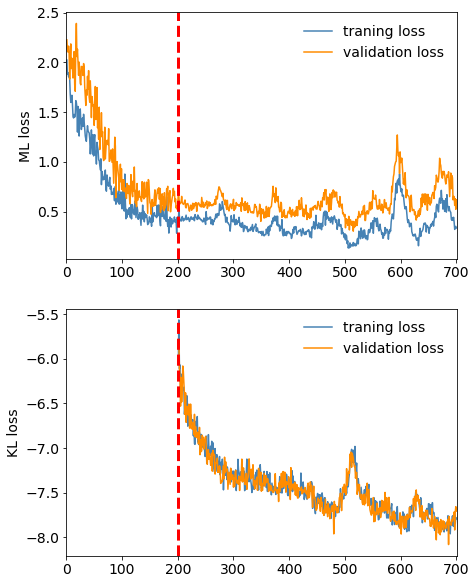

In [25]:
plot_KLML(hist1,hist2,0,2)

### 4. Testing using trained generator

In [26]:
X1, Y1 = test_sample(network1, temperature=1.0, plot=False);
X2, Y2 = test_sample(network2, temperature=1.0, plot=False);
X3, Y3 = test_sample(network3, temperature=1.0, plot=False);

/home/fanglin/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [27]:
nsample=100000

In [28]:
# generate test sample for 100000 steps
_, sample_x1, _, energy_x1, _ = network1.sample(temperature=1.0, nsample=nsample)
_, sample_x2, _, energy_x2, _ = network2.sample(temperature=1.0, nsample=nsample)
_, sample_x3, _, energy_x3, _ = network3.sample(temperature=1.0, nsample=nsample)

In [29]:
# simulation reference
nsteps = 100000
sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_ref = sampler.traj.copy()
sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_ref = sampler.traj.copy()
x_ref = np.vstack([traj_left_ref, traj_right_ref])

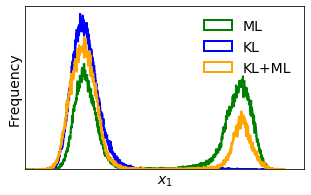

In [30]:
plt.figure(figsize=(5,3))
nsample = 100000
plt.hist(sample_x1[:, 0], 1000, histtype='step', color='green', linewidth=2, label='ML');
plt.hist(sample_x2[:, 0], 1000, histtype='step', color='blue', linewidth=2, label='KL');
plt.hist(sample_x3[:, 0], 1000, histtype='step', color='orange', linewidth=2, label='KL+ML');
plt.xlim(-3, 3)
plt.yticks([]);
plt.xlabel('$x_1$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc='upper right', frameon=False)

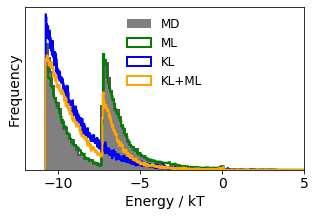

In [31]:
plt.figure(figsize=(5,3))
nsample = 100000
energy_md = double_well.energy(x_ref)
plt.hist(energy_md, 100, density=True, color='grey', linewidth=1, label='MD');
plt.hist(energy_md, 100, density=True, histtype='step', color='#555555', linewidth=2);
plt.hist(energy_x1, 1000, density=True, histtype='step', color='green', linewidth=2, label='ML');
plt.hist(energy_x2, 1000, density=True, histtype='step', color='blue', linewidth=2, label='KL');
plt.hist(energy_x3, 1000, density=True, histtype='step', color='orange', linewidth=2, label='KL+ML');
plt.xlim(-12, 5)
plt.yticks([]);
plt.xlabel('Energy / kT')
plt.ylabel('Frequency')
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)

### Free energy plot

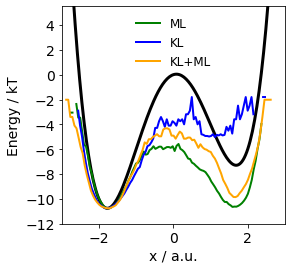

In [32]:
plt.figure(figsize=(4,4))
Ex, E = double_well.plot_dimer_energy(temperature=1.0)
Y1 = Y1 - Y1.min() + E.min()
Y2 = Y2 - Y2.min() + E.min()
Y3 = Y3 - Y3.min() + E.min()
plt.plot(X1, Y1, color='green', linewidth=2, label='ML')
plt.plot(X2, Y2, color='blue', linewidth=2, label='KL')
plt.plot(X3, Y3, color='orange', linewidth=2, label='KL+ML')
plt.xlim(-3, 3)
plt.ylim(-12, 5.5)
plt.yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
#plt.savefig(paper_dir + 'figs/double_well/energy_px.pdf', bbox_inches='tight')

### After reweighting

In [37]:
RX1, RY1, DR1 = test_sample_rew(network1, temperature=1.0, plot=False);
RX2, RY2, DR2 = test_sample_rew(network2, temperature=1.0, plot=False);
RX3, RY3, DR3 = test_sample_rew(network3, temperature=1.0, plot=False);

/home/fanglin/Boltzmann_Generators/deep_boltzmann/deep_boltzmann/sampling/analysis.py:108: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.45859150645781405
Estimator Standard Error:  0.5018770217485868
Estimator Standard Error:  0.5026358714097369


<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

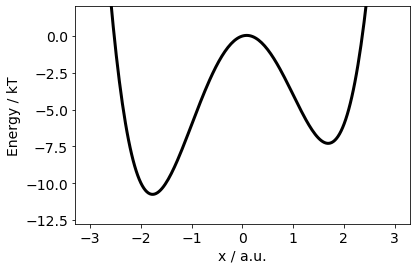

In [38]:
Ex, E = double_well.plot_dimer_energy(temperature=1.0)

Text(0, 0.5, 'Free energy / kT')

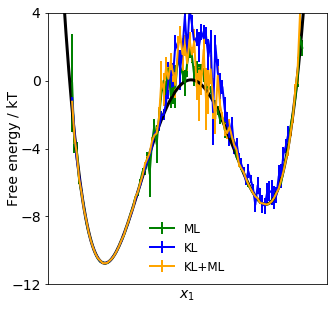

In [41]:
#test_sample_rew(network_NICER_KLRC, temperature=1.0);
plt.figure(figsize=(5,5))
plt.plot(Ex, E, linewidth=3, color='black')
RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
# RY1[RY1 > -4] = np.nan
RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
RY3 = RY3 - RY3[np.isfinite(RY3)].min() + E.min()
plt.errorbar(RX1, RY1, DR1, color='green', linewidth=2, label='ML')
plt.errorbar(RX2, RY2, DR2, color='blue', linewidth=2, label='KL')
plt.errorbar(RX3, RY3, DR3, color='orange', linewidth=2, label='KL+ML')
plt.legend(ncol=1, loc=8, fontsize=12, frameon=False)
plt.xlim(-3, 3)
plt.ylim(-12, 4)
#plt.yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
plt.yticks([-12, -8, -4, 0, 4]);
plt.xticks([]);
plt.xlabel('$x_1$')
plt.ylabel('Free energy / kT', labelpad=-10)

### Lowest Energy Path

In [47]:
xpaths = []
for i in range(10):
    x1 = traj_left[np.random.randint(1000)] 
    x2 = traj_right[np.random.randint(1000)]
    xpaths.append(latent_interpolation(network1, x1, x2, nstep=1000))

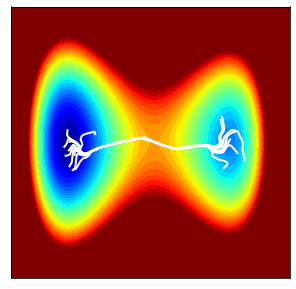

In [48]:
plot_potential(cbar=False, figsize=(5, 5))
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')
for xpath in xpaths:
    plt.plot(xpath[:, 0], xpath[:, 1], linewidth=2, color='white')